In [1]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
DOWNLOAD_ROOT = 'https://www.kaggle.com/datasets/williamu32/imoveis-goiniago/download'
HOUSING_PATH = os.path.join('datasets')
DATA_FILENAME = 'housing.csv'

In [3]:
def fetch_data() -> pd.DataFrame:
    return pd.read_csv(os.path.join(HOUSING_PATH, DATA_FILENAME))

In [4]:
df = fetch_data()
df.head(5)

,DATE,PRICE,ADDRESS,AREAS,BEDROOMS,PARKING-SPACES,BATHROOMS,CONDOMÍNIO,IPTU,TIPO
0,2021-08-05 16:34:17.725797-03:00,Sob consulta,"Rua João de Abreu, Setor Oeste",222 - 485 m²,3 - 4,2 - 4,3 - 5,NaN,NaN,apartamentos
1,2021-08-05 16:34:17.726263-03:00,R$ 430.000,"Rua R 7, Setor Oeste",66 - 68 m²,2,2,2 - 3,NaN,NaN,apartamentos
2,2021-08-05 16:34:17.726628-03:00,R$ 345.000,"Rua 7, Setor Oeste",34 - 76 m²,1 - 2,1,1,NaN,NaN,apartamentos
3,2021-08-05 16:34:17.726966-03:00,R$ 420.000,"Setor Bueno, Goiânia",89 m²,3,1,2,NaN,NaN,apartamentos
4,2021-08-05 16:34:17.727328-03:00,R$ 1.018.000,"Setor Bueno, Goiânia",175 m²,4,5,4,R$ 650,R$ 2.000,apartamentos


# Transfomers

In [5]:
class PriceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, price_ix):
        self.price_ix = price_ix
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X[X.columns[self.price_ix]].replace(['R\$ ', '\.'], '', inplace=True, regex=True)
        X[X.columns[self.price_ix]] = pd.to_numeric(X[X.columns[self.price_ix]], errors='coerce')
        X[X.columns[self.price_ix]] = X[X.columns[self.price_ix]] / 10000
        X[X.columns[self.price_ix]] = X[X.columns[self.price_ix]].astype(float)
        
        return X

In [6]:
class AreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, area_ix):
        self.area_ix = area_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.area_ix]].replace(' m²', '', regex=True, inplace=True)
        X[X.columns[self.area_ix]] = X.iloc[:, self.area_ix].str.split(' - ')
        X[X.columns[self.area_ix]] = X.iloc[:, self.area_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.area_ix]] = X.iloc[:, self.area_ix].apply(np.mean)
        
        return X

In [7]:
class ColumnDropperTransfomer(BaseEstimator, TransformerMixin):
    def __init__(self, data_ix, condominio_ix, iptu_ix, del_data=True, del_condominio=True, del_IPTU=True):
        self.data_ix = data_ix
        self.condominio_ix = condominio_ix
        self.iptu_ix = iptu_ix
        self.del_data = True
        self.del_condominio = True
        self.del_IPTU = True
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        c = 0
        
        if self.del_data:
            X = X.drop(X.columns[self.data_ix], axis=1) # Deleta data
            c += 1
        
        if self.del_condominio:
            X = X.drop(X.columns[self.condominio_ix - c], axis=1)  # Deleta Condominio
            c += 1
            
        if self.del_IPTU:
            X = X.drop(X.columns[self.iptu_ix - c], axis=1)  # Deleta IPTU
        
        return X

In [8]:
class BedroomsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bedrooms_ix):
        self.bedrooms_ix = bedrooms_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.bedrooms_ix]] = X.iloc[:, self.bedrooms_ix].str.split(' - ')
        X[X.columns[self.bedrooms_ix]] = X.iloc[:, self.bedrooms_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.bedrooms_ix]] = X.iloc[:, self.bedrooms_ix].apply(np.mean)

        return X

In [9]:
class ParkingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, parking_ix):
        self.parking_ix = parking_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.parking_ix]] = X.iloc[:, self.parking_ix].str.split(' - ')
        X[X.columns[self.parking_ix]] = X.iloc[:, self.parking_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.parking_ix]] = X.iloc[:, self.parking_ix].apply(np.mean)

        return X

In [10]:
class BathroomsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bathrooms_ix):
        self.bathrooms_ix = bathrooms_ix
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        X[X.columns[self.bathrooms_ix]] = X.iloc[:, self.bathrooms_ix].str.split(' - ')
        X[X.columns[self.bathrooms_ix]] = X.iloc[:, self.bathrooms_ix].apply(lambda x : list(map(float, x)) if isinstance(x, list) else x)
        X[X.columns[self.bathrooms_ix]] = X.iloc[:, self.bathrooms_ix].apply(np.mean)

        return X

In [11]:
class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ignore_columns:list[str]):
        self.ignore_columns = ignore_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for column in X.columns:
            if column not in self.ignore_columns:
                Q1 = X[column].quantile(0.25)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1
                Lower_Whisker = Q1 - 1.5 * IQR
                Upper_Whisker = Q3 + 1.5 * IQR
                
                if (Lower_Whisker < 0):
                    Lower_Whisker = 0
                
                X.drop(X[(X[column] <= Lower_Whisker) | (X[column] >= Upper_Whisker)].index, axis=0, inplace=True)
                
        return X

# Pipeline

In [12]:
area_ix, bedrooms_ix, parking_ix, bathroom_ix = 0, 1, 2, 3
area_org_ix, bedrooms_org_ix, parking_org_ix, bathroom_org_ix = 3, 4, 5, 6
num_attrs = ['AREAS', 'BEDROOMS', 'PARKING-SPACES', 'BATHROOMS']


num_pipeline = Pipeline([
    ('price', PriceTransformer(price_ix=1)),
    ('area', AreaTransformer(area_org_ix)),
    ('bedroom', BedroomsTransformer(bedrooms_org_ix)),
    ('parking', ParkingTransformer(parking_org_ix)),
    ('bathroom', BathroomsTransformer(bathroom_org_ix)),
    ('outliers', RemoveOutliersTransformer(ignore_columns=['DATE', 'ADDRESS', 'TIPO', 'BEDROOMS', 'CONDOMÍNIO', 'IPTU']))
])

type_pipeline = ColumnTransformer([
    ('oh', OneHotEncoder(), ['TIPO']),
])

pos_pipeline = Pipeline([
    ('cat', type_pipeline),
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler(with_mean=False))
])

full_pipeline = Pipeline([
    ('numeral', num_pipeline),
    ('pos', pos_pipeline)
])

full_pipeline

Pipeline(steps=[('numeral',
                 Pipeline(steps=[('price', PriceTransformer(price_ix=1)),
                                 ('area', AreaTransformer(area_ix=3)),
                                 ('bedroom',
                                  BedroomsTransformer(bedrooms_ix=4)),
                                 ('parking', ParkingTransformer(parking_ix=5)),
                                 ('bathroom',
                                  BathroomsTransformer(bathrooms_ix=6)),
                                 ('outliers',
                                  RemoveOutliersTransformer(ignore_columns=['DATE',
                                                                            'ADDRESS',
                                                                            'TIPO',
                                                                            'BEDROOMS',
                                                                            'CONDOMÍNIO',
                                                                            'IPTU']))])),
                ('pos',
                 Pipeline(steps=[('cat',
                                  ColumnTransformer(transformers=[('oh',
                                                                   OneHotEncoder(),
                                                                   ['TIPO'])])),
                                 ('imputer', SimpleImputer()),
                                 ('std_scaler',
                                  StandardScaler(with_mean=False))]))])

In [13]:
df = fetch_data()

df = num_pipeline.fit_transform(df)

df.drop(columns=['DATE', 'ADDRESS', 'CONDOMÍNIO', 'IPTU'], inplace=True)
df.dropna(inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42) 

for train_index, test_index in split.split(df, df['TIPO']):
    strat_train_set = df.iloc[train_index] 
    strat_test_set = df.iloc[test_index]

In [14]:
Y_train = strat_train_set['PRICE']
X_train = strat_train_set.drop('PRICE', axis=1).copy()

Y_test = strat_test_set['PRICE']
X_test = strat_test_set.drop('PRICE', axis=1).copy()

In [15]:
train_data_prepared = pos_pipeline.fit_transform(X_train)
test_data_prepared = pos_pipeline.fit_transform(X_test)

In [16]:
print('Type \t Len X \t Len Y')
print(f'Train \t {len(X_train)} \t {len(Y_train)}')
print(f'Test \t {len(X_test)} \t {len(Y_test)}')

Type 	 Len X 	 Len Y
Train 	 13312 	 13312
Test 	 3329 	 3329


# Exploração dos Dados

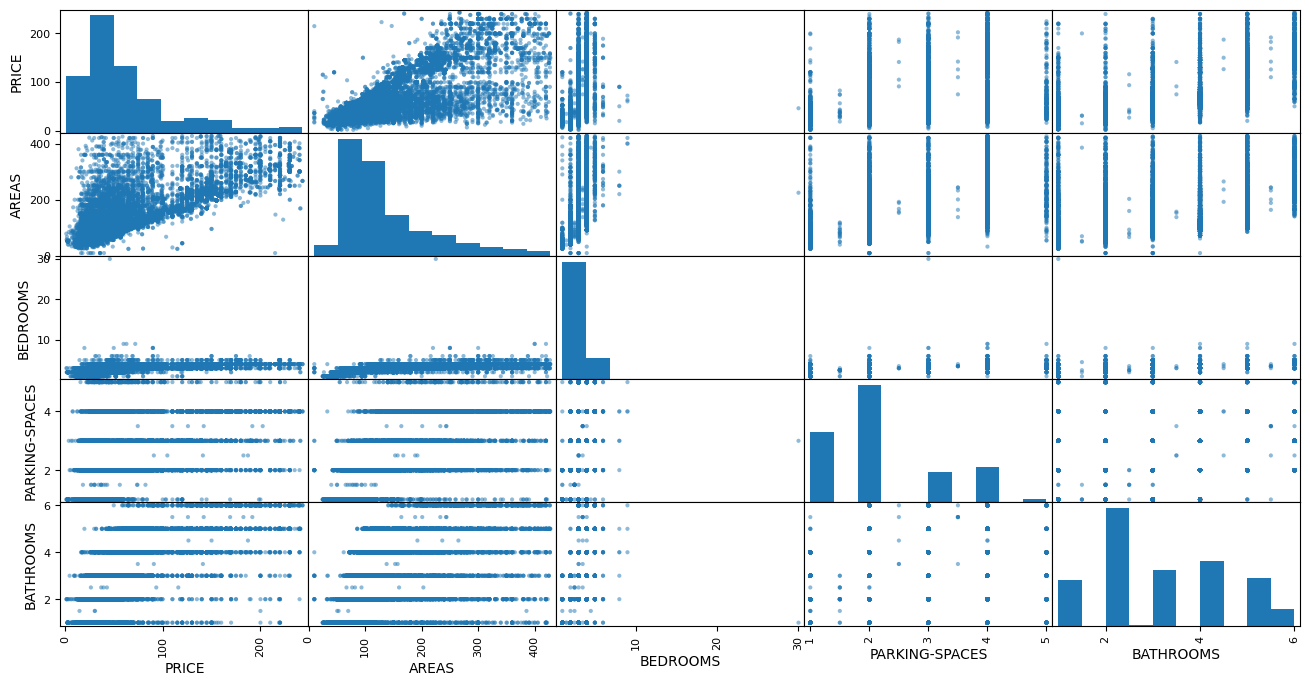

In [17]:
scatter_matrix(df, marker='.', figsize=(16, 8));

Possível relação linear entre Area e Preço

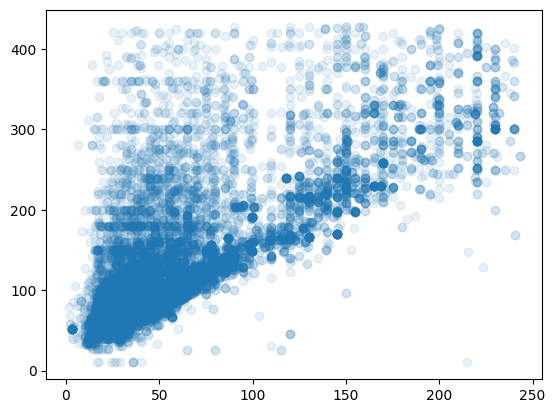

In [18]:
plt.scatter(df['PRICE'], df['AREAS'], alpha=.1);

In [19]:
df.corr(numeric_only=True)

,PRICE,AREAS,BEDROOMS,PARKING-SPACES,BATHROOMS
PRICE,1.000000,0.742853,0.550630,0.615212,0.728898
AREAS,0.742853,1.000000,0.619363,0.728086,0.544708
BEDROOMS,0.550630,0.619363,1.000000,0.552917,0.572687
PARKING-SPACES,0.615212,0.728086,0.552917,1.000000,0.506142
BATHROOMS,0.728898,0.544708,0.572687,0.506142,1.000000


Boa relação de preço com área

# Treinando Modelo

## Regressão Linear

In [20]:
lin_reg = LinearRegression()

In [21]:
lin_reg.fit(train_data_prepared, Y_train)

LinearRegression()

### Testando Modelo

In [22]:
final_predictions = lin_reg.predict(test_data_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mse

1804.845886339662

## Random Forest Regressor

In [23]:
rnd_for = RandomForestRegressor()
rnd_for.fit(train_data_prepared, Y_train)

RandomForestRegressor()

### Testando Modelo

In [24]:
final_predictions = rnd_for.predict(test_data_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mse

1804.6008090306073

# Tentando Melhorar Modelo

## Random Forest Regressor

In [25]:
dist = {
    'n_estimators' : [x for x in range (10, 101, 10)],
    'max_features' : [x for x in range(20, 51, 5)],
    'max_depth' : [x for x in range(20, 51, 5)],
}

grid_search = GridSearchCV(rnd_for, dist, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(train_data_prepared, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [20, 25, 30, 35, 40, 45, 50],
                         'max_features': [20, 25, 30, 35, 40, 45, 50],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=35, max_features=35, n_estimators=10)

In [27]:
predict_values = grid_search.best_estimator_.predict(test_data_prepared)
final_mse = mean_squared_error(Y_test, predict_values)
final_rmse = np.sqrt(final_mse)
final_mse

1804.298826580793

In [28]:
def plotRegressor(y_test, y_pred, regressorName:str, figsize=(20, 8)):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', alpha=.1, label='Verdadeiro')
    plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=.1, label='Predict')
    plt.legend()
    plt.title(regressorName)
    plt.show()

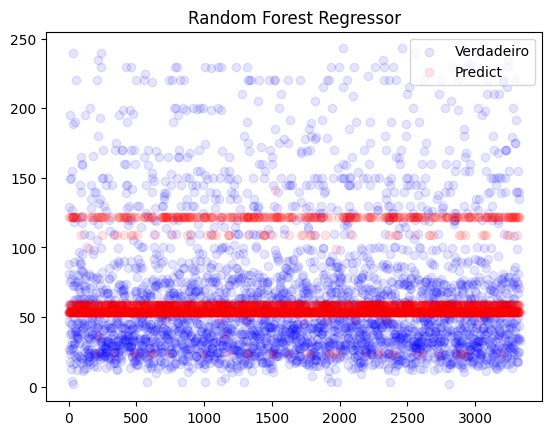

In [29]:
plotRegressor(Y_test, predict_values, 'Random Forest Regressor')

# Salvando Modelo

In [30]:
MODELS_PATH = os.path.join("models")
os.makedirs(MODELS_PATH, exist_ok=True)

joblib.dump(lin_reg, MODELS_PATH + '\model_linear_reg.pkl')
joblib.dump(grid_search.best_estimator_, MODELS_PATH + '\model_tree_regressor.pkl')

['models\\model_tree_regressor.pkl']